In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

In [19]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Standard normalization for CIFAR datasets
])

train_dataset = datasets.ImageFolder(root='/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = datasets.ImageFolder(root='/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [20]:
class CIFakeNet(nn.Module):
    def __init__(self):
        super(CIFakeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=2)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Calculate the flattened size after conv and pool layers (assuming input image size is 32x32)
        self.flattened_size = 32 * 9 * 9
        
        # Define fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)  # first hidden layer
        self.fc2 = nn.Linear(128, 64)                   # second hidden layer
        self.fc3 = nn.Linear(64, 2)                     # third hidden layer, output layer for 2 classes: REAL & FAKE
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, self.flattened_size)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here as it will be combined with nn.CrossEntropyLoss during training
        
        return x


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [22]:
model = CIFakeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [23]:
model = model.to(device)

In [37]:
model

CIFakeNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2592, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [24]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print statistics
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

print('Finished Training')

Epoch 1, Loss: 0.3312928105537051
Epoch 2, Loss: 0.18386269684687914
Epoch 3, Loss: 0.1504043433302805
Epoch 4, Loss: 0.12848643707951635
Epoch 5, Loss: 0.11344535655675125
Epoch 6, Loss: 0.09731006359542056
Epoch 7, Loss: 0.08259230459100607
Epoch 8, Loss: 0.07272029162717653
Epoch 9, Loss: 0.06077305508821593
Epoch 10, Loss: 0.052729858933415884
Finished Training


In [25]:
# Assuming you have a DataLoader called test_loader for your test dataset

# Set the model to evaluation mode
model.eval()

# Variables to keep track of correct predictions and total predictions
correct = 0
total = 0

# No need to track gradients during testing, so use torch.no_grad()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        
        # Update total and correct counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Accuracy on test dataset: {accuracy}%")


Accuracy on test dataset: 94.775%


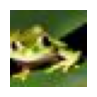

The image is FAKE


In [38]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Load the image
img_path = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE/10 (7).jpg"
image = Image.open(img_path)

# Display the image
plt.figure(figsize=(1,1))
plt.imshow(image)
plt.axis('off')
plt.show()

# Define the necessary transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),               # Resize to 32x32
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5),     # Normalize - adjust these values if you used different ones during training
                        (0.5, 0.5, 0.5))
])

# Apply transformations
image_tensor = transform(image)

# Add a batch dimension
image_tensor = image_tensor.unsqueeze(0).to(device)

# Model prediction
model.eval()
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs.data, 1)
    if predicted.item() == 0:  # Assuming 0 is the class index for 'REAL'
        print("The image is FAKE")
    else:
        print("The image is REAL")


In [39]:
torch.save(model, 'cifake_model.pth')

In [40]:
# model = torch.load('model_path.pth')
# model.eval()